In [41]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from data_assimilation import assimilate_lorenz, assimilate_lorenz_weighted


def plot_models_coords_in_time(models, timelines):
    f, (px, py, pz) = plt.subplots(3, 1, sharex=True, figsize=(15, 8))

    px.set_ylabel("X component")
    py.set_ylabel("Y component")
    pz.set_ylabel("Z component")

    for ix, (model, timeline) in enumerate(zip(models, timelines)):
        px.plot(timeline, model[:, 0], lw=0.5)
        py.plot(timeline, model[:, 1], lw=0.5)
        pz.plot(timeline, model[:, 2], lw=0.5, label=str(ix + 1))

    pz.set_xlabel("Time index (x 100)")

    f.legend(title="Models in order")


def plot_models(models, timelines=None, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
        ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten(), lw=0.5)
    plt.draw()
    plt.show()

    if timelines is not None:
        plot_models_coords_in_time(models, timelines)


def plot_model(model, timeline=None, figsize=(5, 5)):
    if timeline is not None:
        return plot_models([model], [timeline], figsize)
    return plot_models([model], figsize=figsize)


def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:, i, :], axis=0) for i in range(lorenz_models.shape[1])])


def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array(
        [np.average(lorenz_models[:, i, :], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])


def lorenz_step(coords, parameters, dt=0.01):
    rho, sigma, beta = parameters
    x, y, z = coords
    return coords + (np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z]) * dt)


def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0 / 3.0, start_time=0.0, number_of_samples=4000,
                    dt=0.01, plot=False):
    size = number_of_samples

    if start_time:
        size += ceil(start_time / dt)

    coords = np.empty([size, 3])

    coords[0] = [x, y, z]
    parameters = [rho, sigma, beta]
    for i in range(size - 1):
        coords[i + 1] = lorenz_step(coords[i], parameters, dt=dt)
    coords = coords[-number_of_samples:]
    if plot:
        plot_model(coords)
    return coords, np.arange(start_time, start_time + number_of_samples * dt, dt)


def lorenz_research(
        start_time=0,
        number_of_samples=200,
        steps_4dvar=50,
        small_plot=True,
        full_plot=True,
        initial_params=None
):
    l63_gt, l63_timeline_gt = generate_lorenz(
        start_time=start_time,
        number_of_samples=number_of_samples
    )

    initial = dict(
        x=l63_gt[0][0],
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma=10.0,
        rho=20.,
        beta=5.
    )

    if initial_params is not None:
        initial.update(initial_params)

    error_vector = [0.1, 0.1, 0.1, 100, 100, 100]

    coords_and_params = assimilate_lorenz(
        initial,
        l63_gt,
        lorenz_step,
        maximum_number_of_steps=steps_4dvar,
        verbose=True,
        error_vector=error_vector
    )
    l63_4dv, l63_4dv_timeline = generate_lorenz(
        x=l63_gt[0][0],
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma=coords_and_params['sigma'],
        rho=coords_and_params['rho'],
        beta=coords_and_params['beta'],
        number_of_samples=number_of_samples
    )

    if small_plot:
        plot_models(
            [l63_gt, l63_4dv],
            [l63_timeline_gt, l63_timeline_gt]
        )

    full_lorenz, fl_timeline = generate_lorenz()
    full_predicted, full_pred_timeline = generate_lorenz(sigma=coords_and_params['sigma'], rho=coords_and_params['rho'],
                                                         beta=coords_and_params['beta'])

    if full_plot:
        plot_models([full_lorenz, full_predicted], [fl_timeline, full_pred_timeline])

    return {
        'partial': {
            'gt': [l63_gt, l63_timeline_gt],
            'pred': [l63_4dv, l63_4dv_timeline],
        },
        'full': {
            'gt': [full_lorenz, fl_timeline],
            'pred': [full_predicted, full_pred_timeline],
        }
    }


def set_submodel_consts(
        number_of_samples=200,
        steps_4dvar=20,
        start_time= 4.5,
):
    def create_submodel(sigma, rho, beta):
        return lorenz_research(
            number_of_samples=number_of_samples,
            steps_4dvar=steps_4dvar,
            start_time=start_time,
            small_plot=True,
            full_plot=False,
            initial_params=dict(sigma=sigma, rho=rho, beta=beta)
        )

    return create_submodel

  Intermediate CurrentState at the current iteration: [ 7.73576289  6.24686557 28.01674814 28.         10.          3.        ]
  Intermediate CurrentState at the current iteration: [ 7.79440047  6.29113529 28.15607396 27.76248223  9.94486017  2.04305954]
  Intermediate CurrentState at the current iteration: [ 7.75412958  6.2607319  28.0603883  27.92560378  9.98272889  2.70026346]
  Intermediate CurrentState at the current iteration: [ 7.75452569  6.26535337 28.05745812 27.93028138  9.98278521  2.69395464]
  Intermediate CurrentState at the current iteration: [ 7.75505987  6.28232286 28.0439816  27.95181261  9.98357115  2.68127802]
Calibration of 6 coefficients on 100 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [ 7.75505987  6.28232286 28.0439816  27.95181261  9.98357115  2.68127802]
  Intermediate CurrentState at the current iteration: [ 7.73576289  6.24686557 28.01674814 28.          9.          2.66666667]
  Int

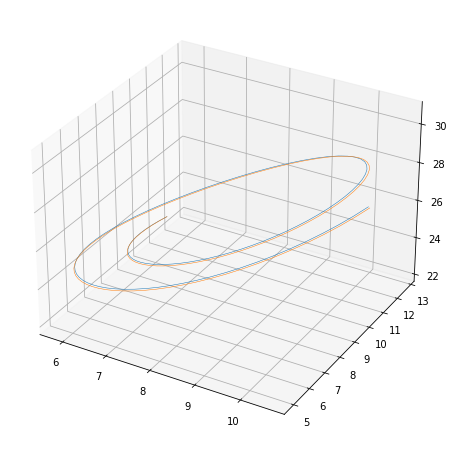

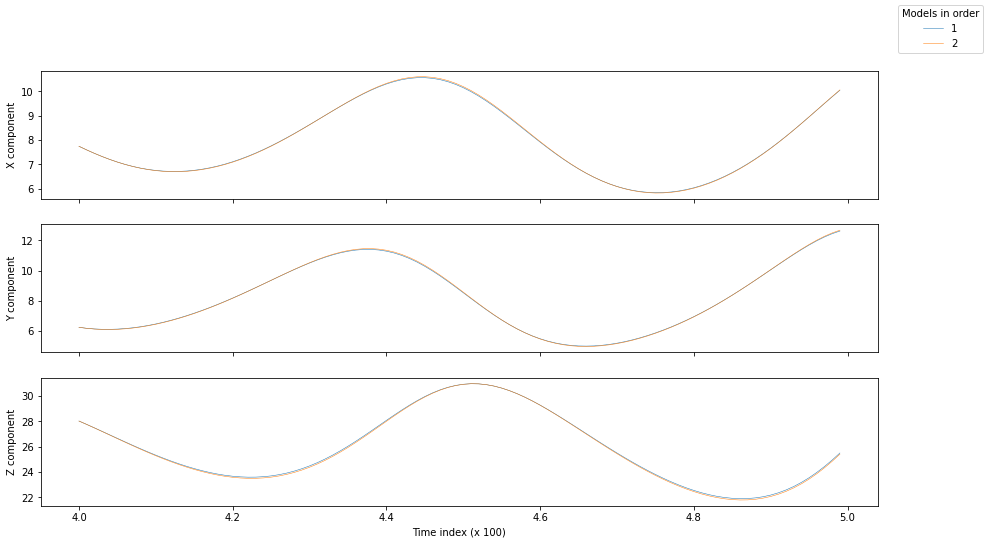

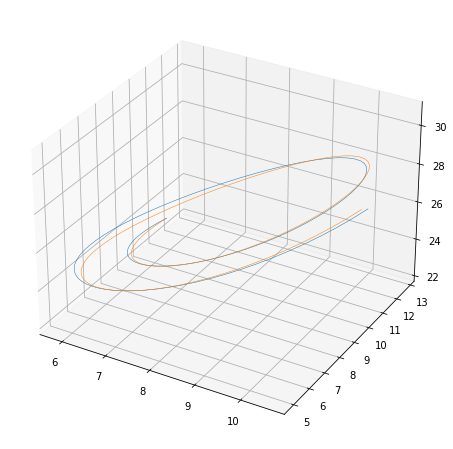

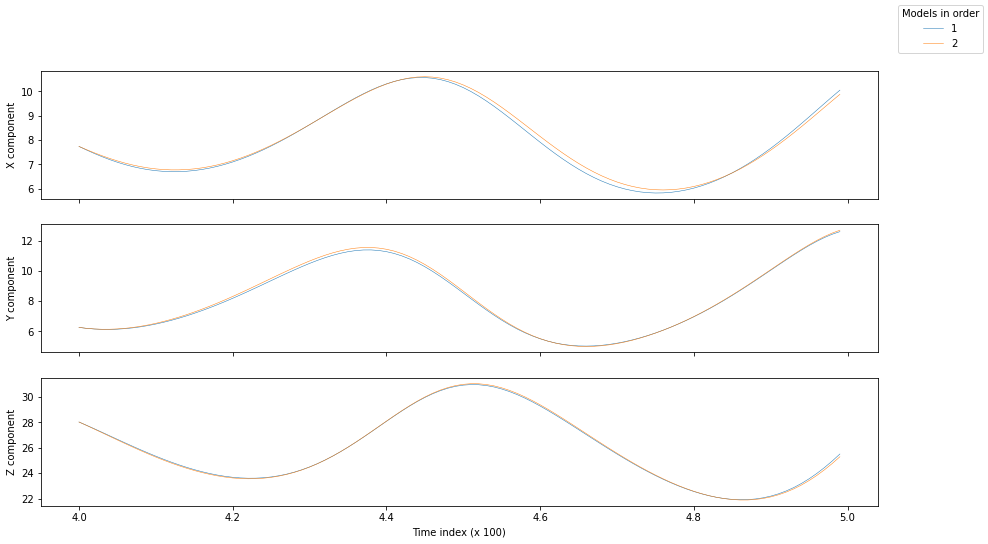

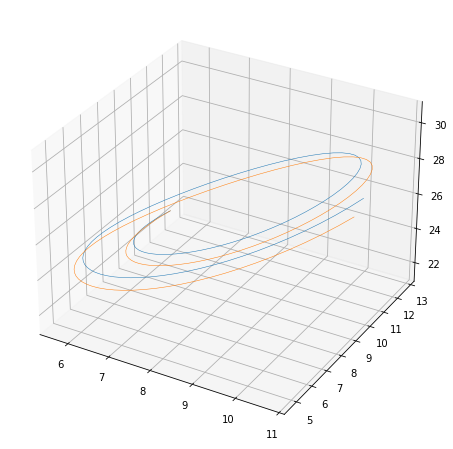

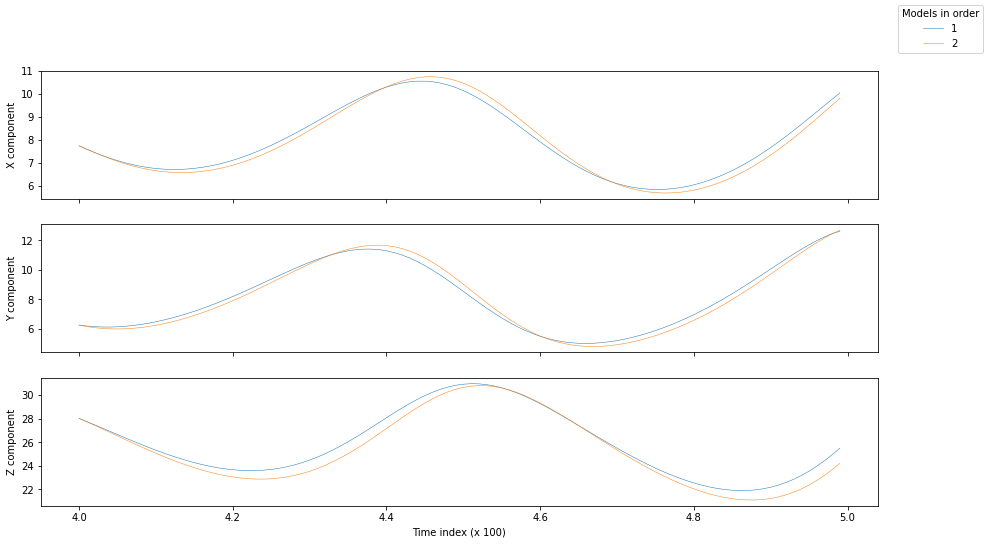

In [42]:
submodel_creator = set_submodel_consts(
    number_of_samples = 100,
    steps_4dvar = 5,
    start_time=4,
)

sm1 = submodel_creator(
    sigma=10,
    rho=28,
    beta=9./3.,
)

sm2 = submodel_creator(
    sigma=9,
    rho=28,
    beta=8./3.,
)

sm3 = submodel_creator(
    sigma=10,
    rho=27,
    beta=8./3.,
)

In [43]:
def obertvator_kind(kind):
    def observator(springs):
        c12, c13, c21, c23, c31, c32 = list(np.ravel(springs))
        m1 = sm1[kind]['pred'][0].copy()
        m2 = sm2[kind]['pred'][0].copy()
        m3 = sm3[kind]['pred'][0].copy()
        x1 = m1[:, 0]
        x2 = m2[:, 0]
        x3 = m3[:, 0]
        m1[:, 0] += c12 * (x1 - x2) + c13 * (x1 - x3)
        m2[:, 0] += c21 * (x2 - x1) + c23 * (x2 - x3)
        m3[:, 0] += c31 * (x3 - x1) + c32 * (x3 - x2)

        return calc_mean_lorenz(np.array([m1, m2,m3,]))
    return observator


predicted_springs_for_x = assimilate_lorenz_weighted([1., 1., 1., 1., 1., 1.], sm1['full']['gt'][0], obertvator_kind('full'))

  Intermediate CurrentState at the current iteration: [1. 1. 1. 1. 1. 1.]
  Intermediate CurrentState at the current iteration: [1.         1.         1.         1.         0.03286202 1.25425208]
  Intermediate CurrentState at the current iteration: [1.         1.         1.         1.         0.63845205 1.09504778]
  Intermediate CurrentState at the current iteration: [0.98625363 1.01623478 0.99765647 0.99375894 0.50546562 0.96324759]
  Intermediate CurrentState at the current iteration: [0.95987787 1.04399293 1.00961615 1.02508708 0.26970347 0.72478651]
  Intermediate CurrentState at the current iteration: [0.96050059 1.04362293 1.00891359 1.02386588 0.2741177  0.72991534]
  Intermediate CurrentState at the current iteration: [0.96045708 1.04359704 1.00899578 1.02392256 0.27407376 0.7296567 ]
  Intermediate CurrentState at the current iteration: [0.96045788 1.04360094 1.00899197 1.02392318 0.27405048 0.72965667]
Calibration of 6 coefficients on 12000 measures
------------------------

In [44]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

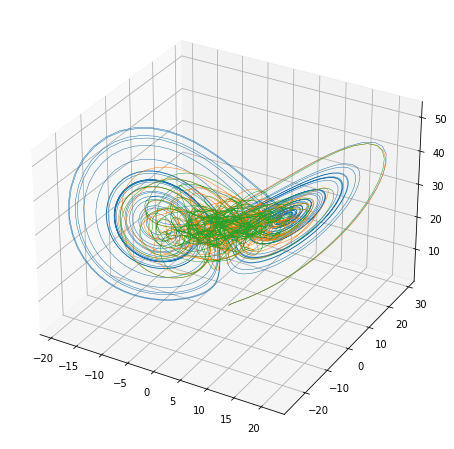

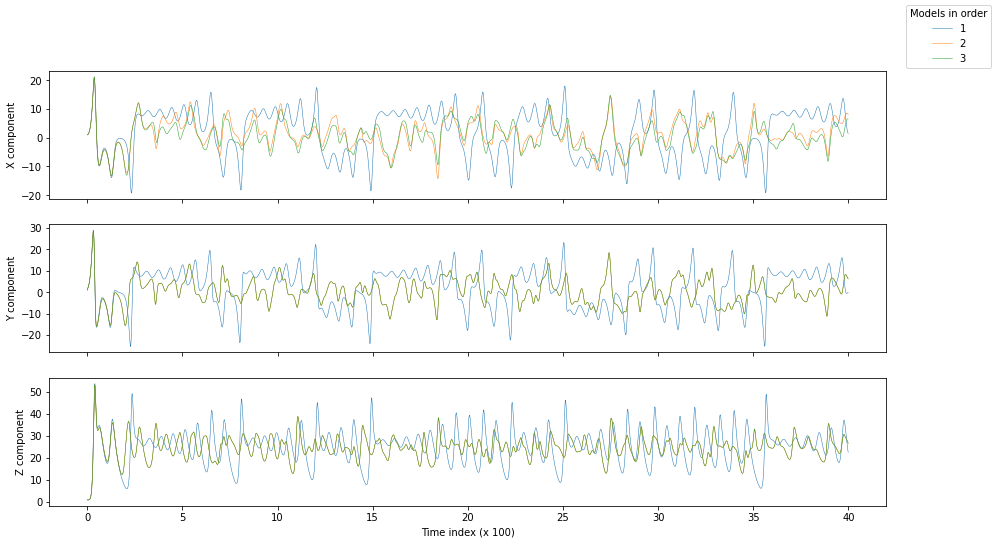

In [45]:
springed_values = obertvator_kind('full')(predicted_springs_for_x)
plot_models(
    [sm1['full']['gt'][0],
    springed_values,
     mean_submodel,
    ],
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)